Required packets

In [1]:
from scipy.signal import find_peaks
import torch
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Peek Detection

Load the transform and retrive the right threshold based on the scale, need to understand how to deal with trend probably must be sum

In [2]:
series = read_csv('coefficents.csv', header = 0, index_col = 0, parse_dates= True).squeeze('columns')

# Initialize lists to store coefficients and heights
wav_coef = []
height = []
time_index = series.index
time_diff = time_index.to_series().diff().min()
rows = series.shape[0]
columns = series.shape[1]

# To decide the threshold based on the sampling frequency
daily_threshold = pd.Timedelta(days=1)
weekly_threshold = pd.Timedelta(weeks=1)
monthly_threshold = pd.Timedelta(days=28)

print(time_diff)

if time_diff < daily_threshold:
  time_diff = 0
  final_result = torch.zeros(rows, columns // 4, 4)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)

      # Determine the height based on the column name or any other criteria
      if 'daily' in column.lower():
          height.append(1)
      elif 'weekly' in column.lower():
          height.append(2)
      elif 'monthly' in column.lower():
          height.append(4)
      elif 'yearly' in column.lower():
          height.append(15)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == daily_threshold:
  time_diff = 1
  final_result = torch.zeros(rows, columns // 3, 3)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)

      # Determine the height based on the column name or any other criteria
      if 'weekly' in column.lower():
          height.append(0.5)
      elif 'monthly' in column.lower():
          height.append(1)
      elif 'yearly' in column.lower():
          height.append(2)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == weekly_threshold:
  time_diff = 2
  final_result = torch.zeros(rows, columns // 2, 2)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)


      if 'monthly' in column.lower():
          height.append(0.5)
      elif 'yearly' in column.lower():
          height.append(1)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == monthly_threshold:
  time_diff = 3
  final_result = torch.zeros(rows, columns, 1)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)

      if 'yearly' in column.lower():
          height.append(1)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")

print(height)

0 days 01:00:00
[1, 2, 4, 15, 1, 2, 4, 15, 1, 2, 4, 15, 1, 2, 4, 15, 1, 2, 4, 15, 1, 2, 4, 15, 1, 2, 4, 15]


Find the index for each scale of those part with a match higher then the threshold

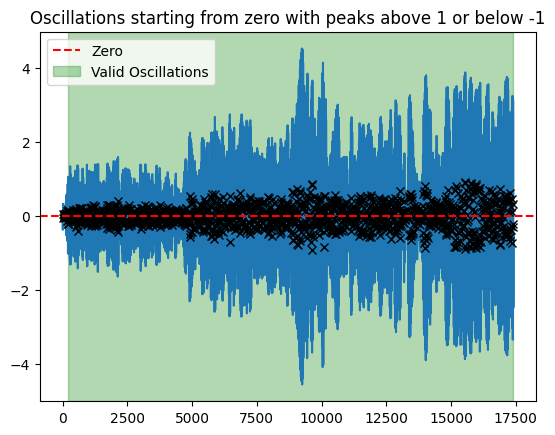

No consecutive index 237-273
No consecutive index 320-405
No consecutive index 616-751
No consecutive index 799-919
No consecutive index 968-1003
No consecutive index 1061-1086
No consecutive index 1268-1328
No consecutive index 1378-1703
No consecutive index 1822-1895
No consecutive index 2158-2291
No consecutive index 2470-2495
No consecutive index 2650-2986
No consecutive index 3119-3178
No consecutive index 3238-3275
No consecutive index 3346-3443
No consecutive index 3479-3599
No consecutive index 3658-3718
No consecutive index 3766-4043
No consecutive index 4090-4354
No consecutive index 4389-4690
No consecutive index 4795-4865
No consecutive index 5140-5175
No consecutive index 6681-6706
No consecutive index 7315-7352
No consecutive index 7831-7856
No consecutive index 8011-8036
No consecutive index 8251-8289
No consecutive index 8757-8805
No consecutive index 11000-11095
No consecutive index 11216-11253
No consecutive index 12767-12801
No consecutive index 13089-13172
No consec

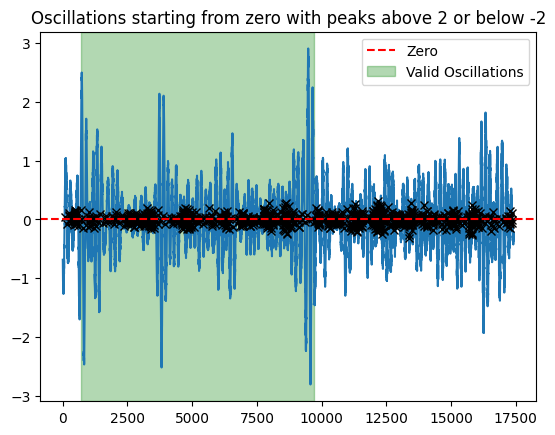

No consecutive index 867-3689
No consecutive index 3942-9342
[ 689  690  691  692  693  694  695  696  697  698  699  700  701  702
  703  704  705  706  707  708  709  710  711  712  713  714  715  716
  717  718  719  720  721  722  723  724  725  726  727  728  729  730
  731  732  733  734  735  736  737  738  739  740  741  742  743  744
  745  746  747  748  749  750  751  752  753  754  755  756  757  758
  759  760  761  762  763  764  765  766  767  768  769  770  771  772
  773  774  775  776  777  778  779  780  781  782  783  784  785  786
  787  788  789  790  791  792  793  794  795  796  797  798  799  800
  801  802  803  804  805  806  807  808  809  810  811  812  813  814
  815  816  817  818  819  820  821  822  823  824  825  826  827  828
  829  830  831  832  833  834  835  836  837  838  839  840  841  842
  843  844  845  846  847  848  849  850  851  852  853  854  855  856
  857  858  859  860  861  862  863  864  865  866  867 3689 3690 3691
 3692 3693 3694 

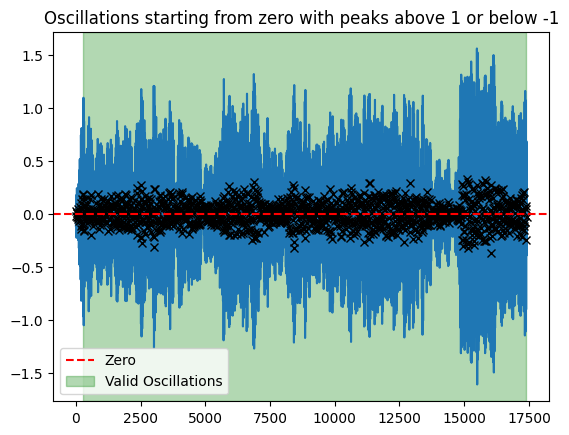

No consecutive index 2578-2999
No consecutive index 3058-3623
No consecutive index 3647-5699
No consecutive index 5736-5905
No consecutive index 5952-6592
No consecutive index 6628-6830
No consecutive index 6939-8393
No consecutive index 8464-8836
No consecutive index 8884-10552
No consecutive index 10647-11129
No consecutive index 11163-11280
No consecutive index 11363-12274
No consecutive index 12310-12671
No consecutive index 12755-12863
No consecutive index 12899-13007
No consecutive index 13055-13371
No consecutive index 13419-14843
No consecutive index 15059-15095
No consecutive index 15311-15359
No consecutive index 15430-15472
No consecutive index 15913-15951
No consecutive index 16209-16428
No consecutive index 16475-17327
[ 2508  2509  2510 ... 17385 17386 17387]
torch.Size([17420, 7, 4])


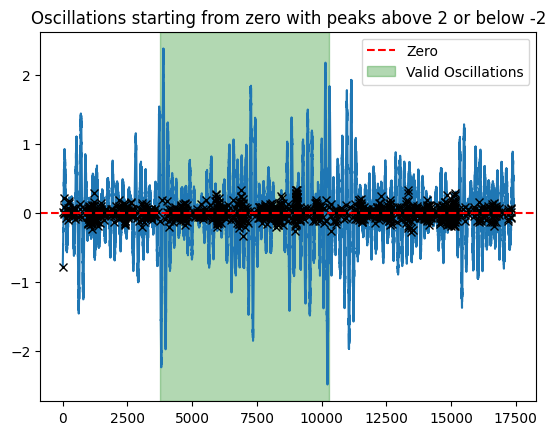

[]
torch.Size([17420, 7, 4])


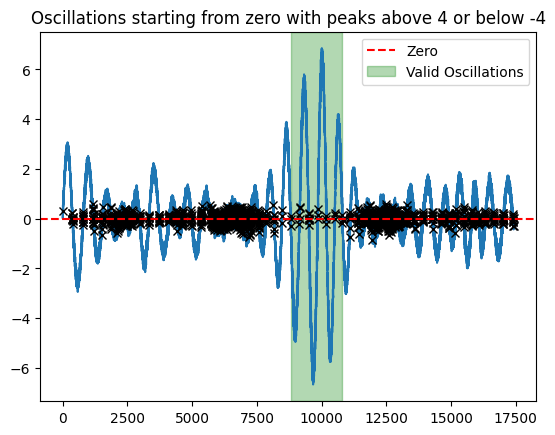

[ 8805  8806  8807 ... 10800 10801 10802]
torch.Size([17420, 7, 4])


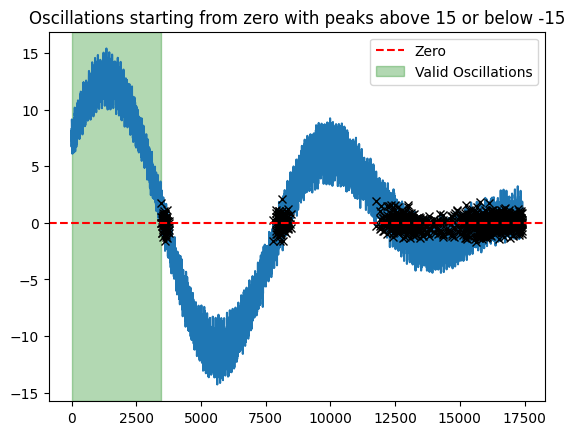

[]
torch.Size([17420, 7, 4])


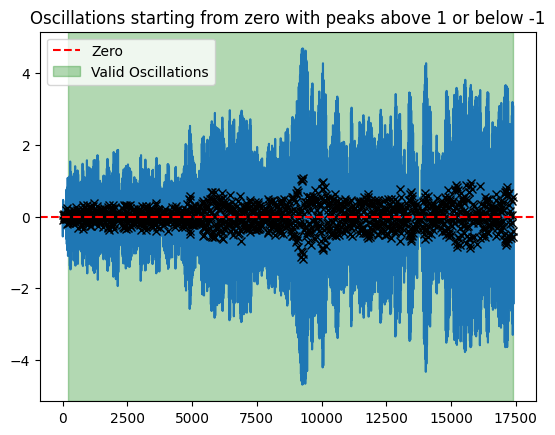

No consecutive index 320-405
No consecutive index 604-740
No consecutive index 861-908
No consecutive index 1390-1558
No consecutive index 1607-1678
No consecutive index 1821-1895
No consecutive index 2169-2291
No consecutive index 2662-2752
No consecutive index 2776-2974
No consecutive index 3118-3166
No consecutive index 3394-3430
No consecutive index 3503-3575
No consecutive index 3670-3706
No consecutive index 3765-3971
No consecutive index 4125-4330
No consecutive index 4389-4582
No consecutive index 4808-4866
No consecutive index 5140-5176
No consecutive index 5210-5248
No consecutive index 7315-7352
No consecutive index 7819-7855
No consecutive index 8011-8036
No consecutive index 11059-11084
No consecutive index 13233-13292
No consecutive index 13712-13867
No consecutive index 14731-14756
[  261   262   263 ... 17411 17412 17413]
torch.Size([17420, 7, 4])


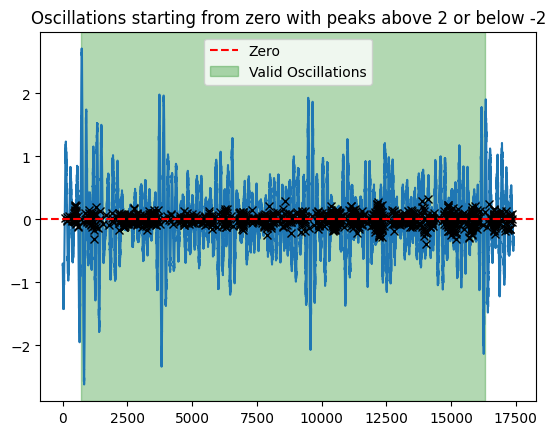

[688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705
 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723
 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741
 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759
 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831
 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849
 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867]
torch.Size([17420, 7, 4])
All points under 4
All points under 15


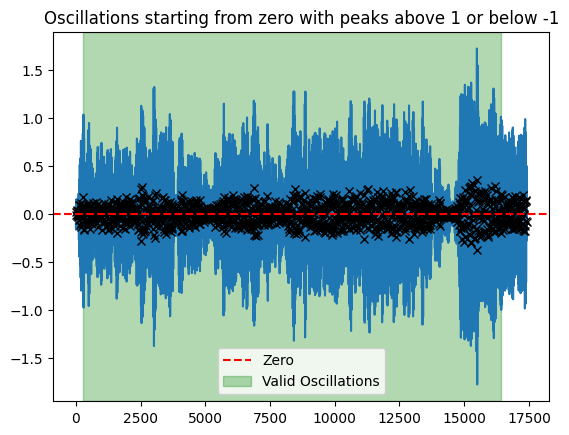

No consecutive index 2602-2986
No consecutive index 3069-5698
No consecutive index 5736-6843
No consecutive index 6928-8381
No consecutive index 8464-8836
No consecutive index 8884-10599
No consecutive index 10647-11117
No consecutive index 11175-11280
No consecutive index 11362-11824
No consecutive index 11858-12262
No consecutive index 12309-12671
No consecutive index 12695-12851
No consecutive index 12887-13019
No consecutive index 13043-13384
No consecutive index 13419-14843
No consecutive index 15058-15107
No consecutive index 15311-15359
No consecutive index 15407-15458
No consecutive index 15563-15952
No consecutive index 15986-16020
No consecutive index 16066-16104
[ 2520  2521  2522 ... 16230 16231 16232]
torch.Size([17420, 7, 4])


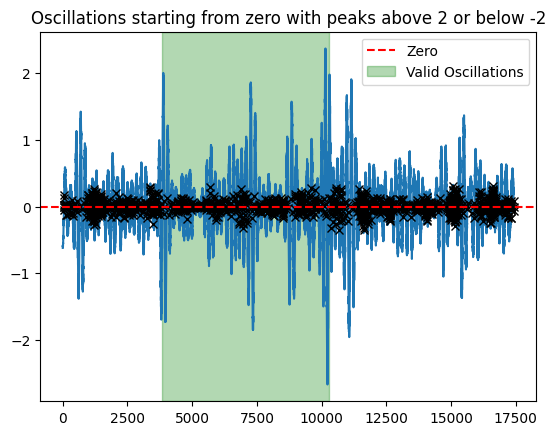

[]
torch.Size([17420, 7, 4])


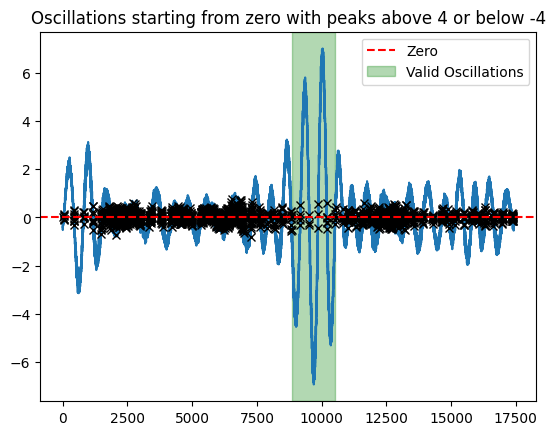

[ 8841  8842  8843 ... 10522 10523 10524]
torch.Size([17420, 7, 4])
All points under 15
All points under 1


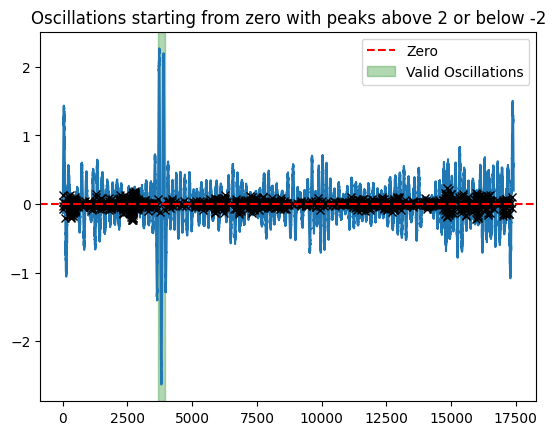

[3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693
 3694 3695 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706 3707
 3708 3709 3710 3711 3712 3713 3714 3715 3716 3717 3718 3719 3720 3721
 3722 3723 3724 3725 3726 3727 3728 3729 3730 3731 3732 3733 3734 3735
 3736 3737 3738 3739 3740 3741 3742 3743 3744 3745 3746 3747 3748 3749
 3750 3751 3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762 3763
 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773 3774 3775 3776 3777
 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787 3788 3789 3790 3791
 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803 3804 3805
 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817 3818 3819
 3820 3821 3822 3823 3824 3825 3826 3827 3828 3829 3830 3831 3832 3833
 3834 3835 3836 3837 3838 3839 3840 3841 3842 3843 3844 3845 3846 3847
 3848 3849 3850 3851 3852 3853 3854 3855 3856 3857 3858 3859 3860 3861
 3862 3863 3864 3865 3866 3867 3868 3869 3870 3871 3872 3873 3874 3875
 3876 

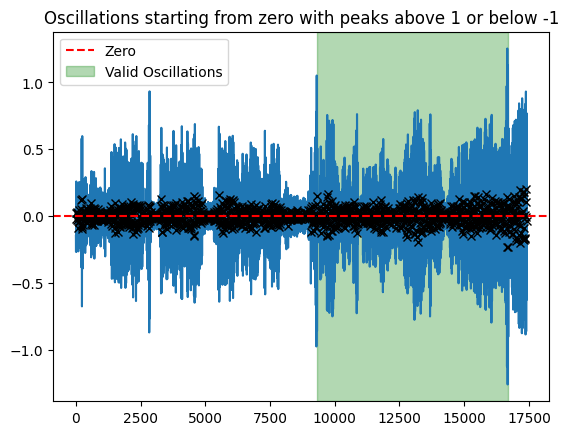

[16647 16648 16649 16650 16651 16652 16653 16654 16655 16656 16657 16658
 16659 16660 16661 16662 16663 16664 16665 16666 16667 16668 16669 16670
 16671 16672 16673 16674 16675 16676 16677 16678 16679 16680 16681 16682
 16683 16684 16685 16686 16687 16688 16689 16690 16691 16692 16693 16694
 16695 16696 16697]
torch.Size([17420, 7, 4])


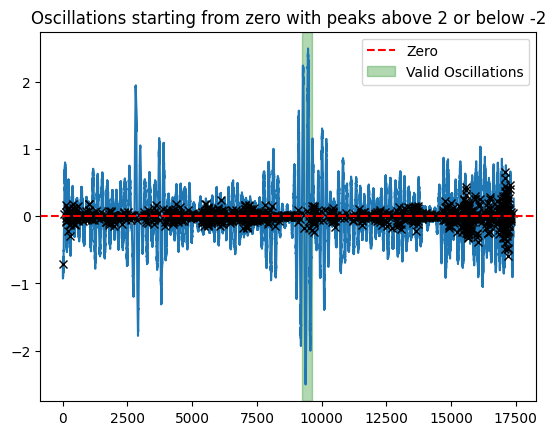

[9240 9241 9242 9243 9244 9245 9246 9247 9248 9249 9250 9251 9252 9253
 9254 9255 9256 9257 9258 9259 9260 9261 9262 9263 9264 9265 9266 9267
 9268 9269 9270 9271 9272 9273 9274 9275 9276 9277 9278 9279 9280 9281
 9282 9283 9284 9285 9286 9287 9288 9289 9290 9291 9292 9293 9294 9295
 9296 9297 9298 9299 9300 9301 9302 9303 9304 9305 9306 9307 9308 9309
 9310 9311 9312 9313 9314 9315 9316 9317 9318 9319 9320 9321 9322 9323
 9324 9325 9326 9327 9328 9329 9330 9331 9332 9333 9334 9335 9336 9337
 9338 9339 9340 9341 9342 9343 9344 9345 9346 9347 9348 9349 9350 9351
 9352 9353 9354 9355 9356 9357 9358 9359 9360 9361 9362 9363 9364 9365
 9366 9367 9368 9369 9370 9371 9372 9373 9374 9375 9376 9377 9378 9379
 9380 9381 9382 9383 9384 9385 9386 9387 9388 9389 9390 9391 9392 9393
 9394 9395 9396 9397 9398 9399 9400 9401 9402 9403 9404 9405 9406 9407
 9408 9409 9410 9411 9412 9413 9414 9415 9416 9417 9418 9419 9420 9421
 9422 9423 9424 9425 9426 9427 9428 9429 9430 9431 9432 9433 9434 9435
 9436 

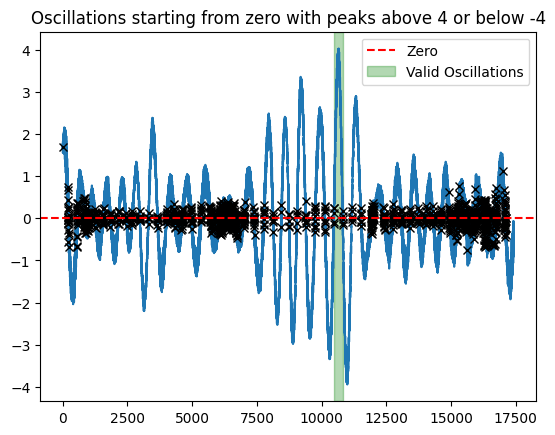

[]
torch.Size([17420, 7, 4])
All points under 15


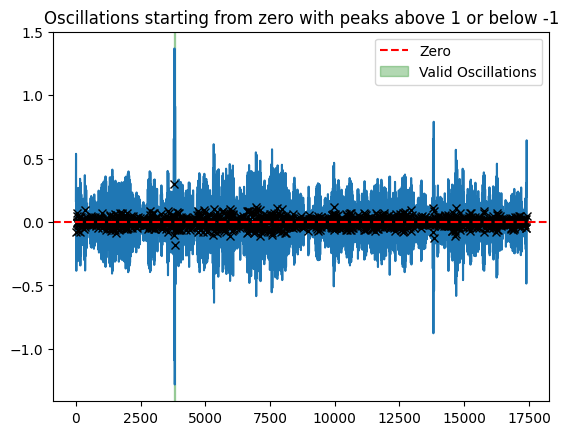

[3790 3791 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803
 3804 3805 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817
 3818 3819 3820 3821 3822 3823 3824 3825 3826]
torch.Size([17420, 7, 4])


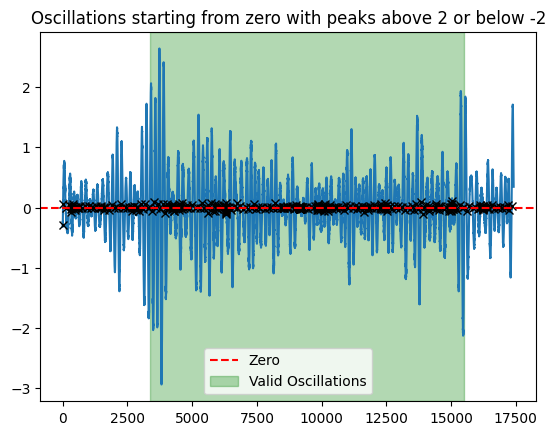

[3366 3367 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379
 3380 3381 3382 3383 3384 3385 3386 3387 3388 3389 3390 3391 3392 3393
 3394 3395 3396 3397 3398 3399 3400 3401 3402 3403 3404 3405 3406 3407
 3408 3409 3410 3411 3412 3413 3414 3415 3416 3417 3418 3419 3420 3421
 3422 3423 3424 3425 3426 3427 3428 3429 3430 3431 3432 3433 3434 3435
 3436 3437 3438 3439 3440 3441 3442 3443 3444 3445 3446 3447 3448 3449
 3450 3451 3452 3453 3454 3455 3456 3457 3458 3459 3460 3461 3462 3463
 3464 3465 3466 3467 3468 3469 3470 3471 3472 3473 3474 3475 3476 3477
 3478 3479 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489 3490 3491
 3492 3493 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503 3504 3505
 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519
 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533
 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547
 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561
 3562 

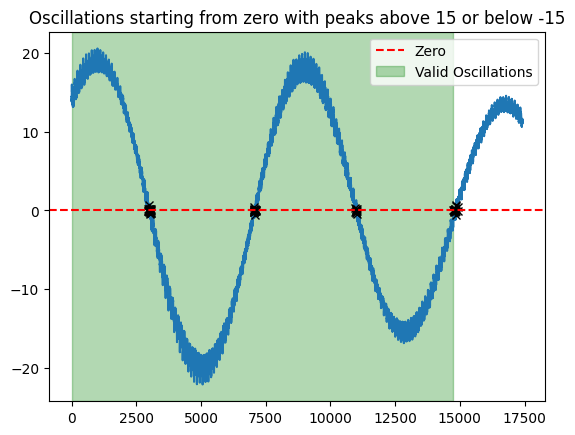

[    0     1     2 ... 14753 14754 14755]
torch.Size([17420, 7, 4])


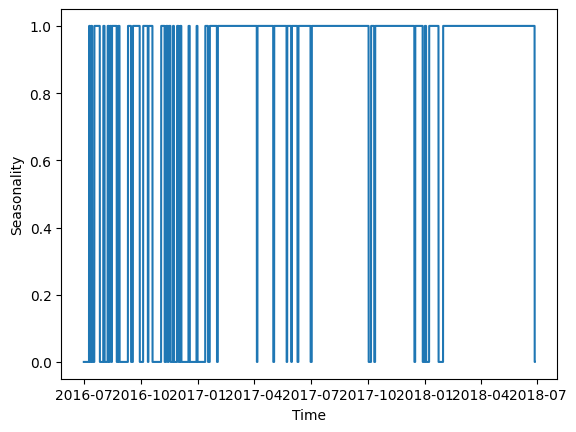

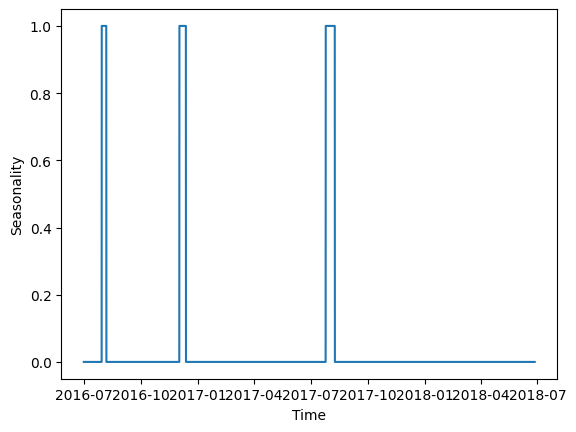

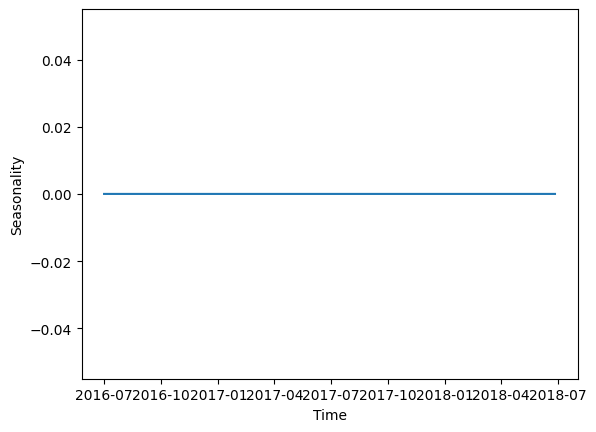

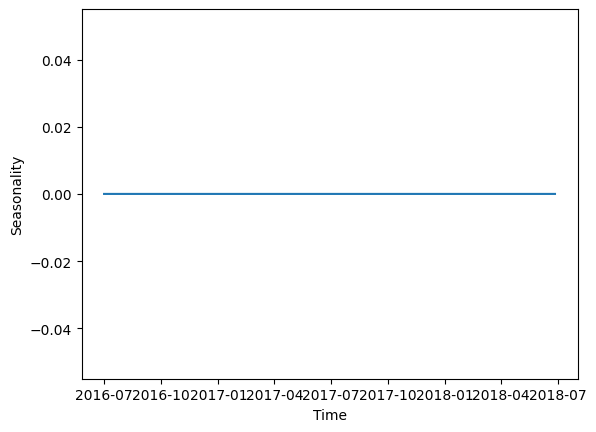

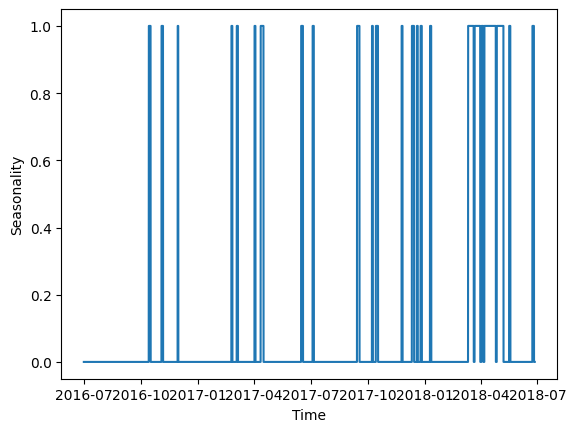

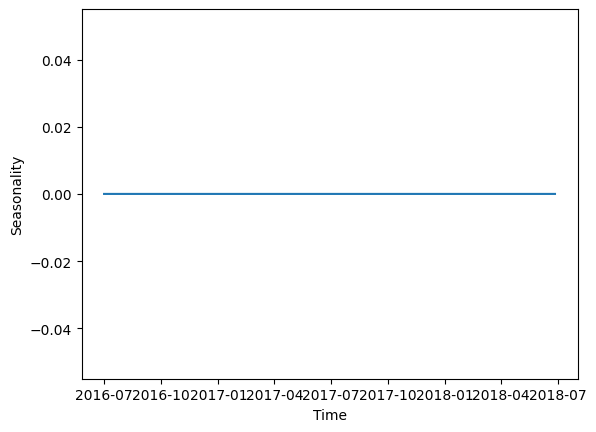

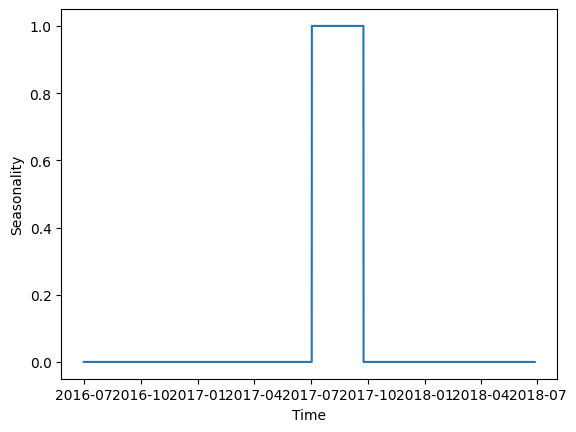

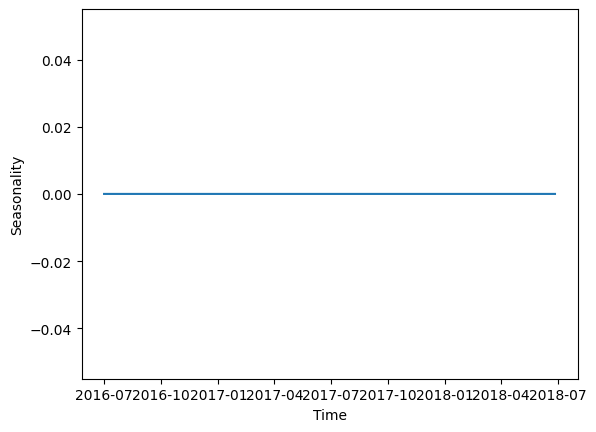

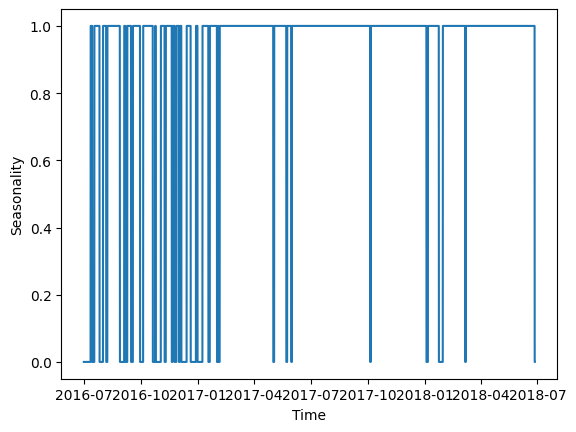

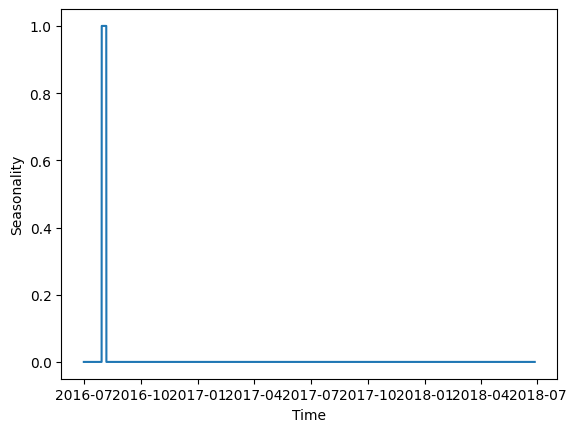

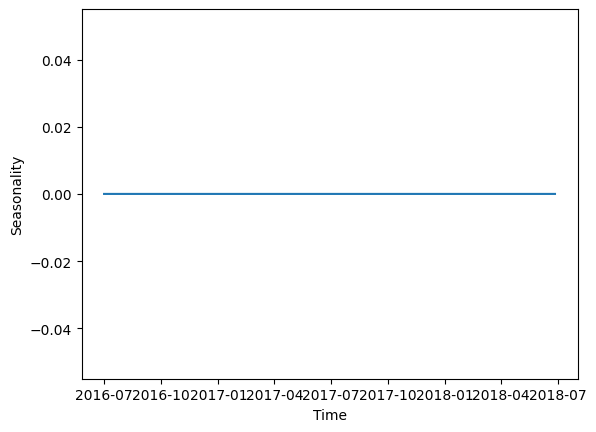

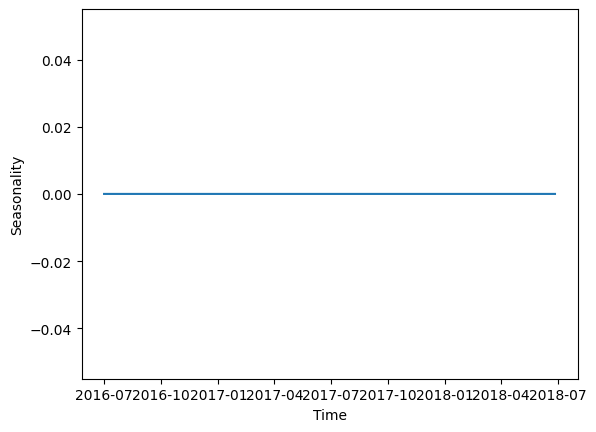

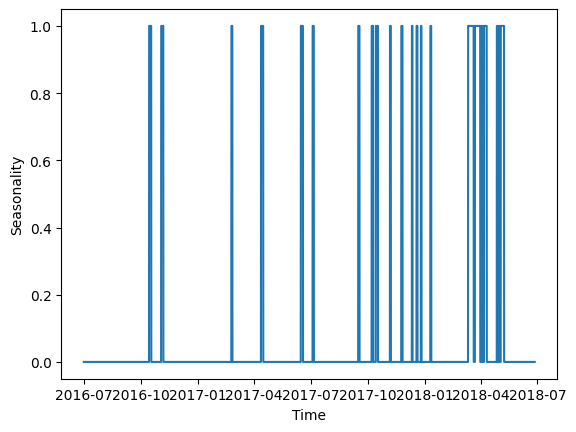

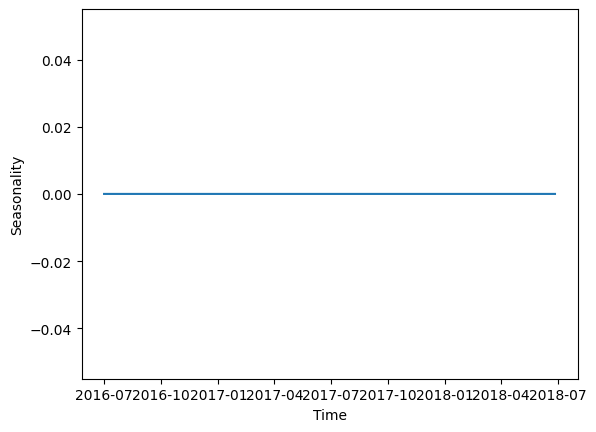

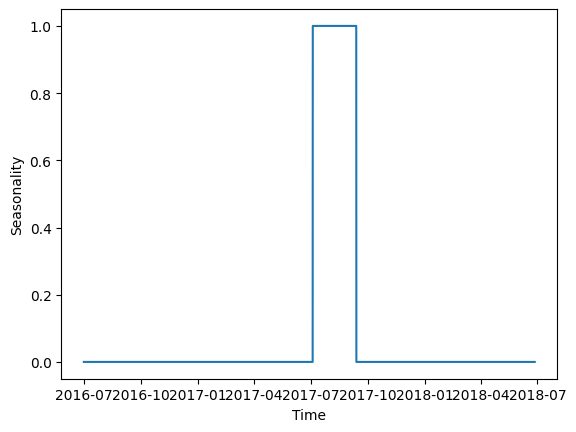

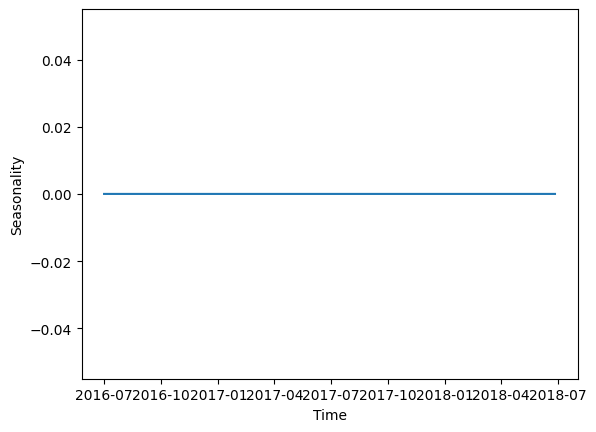

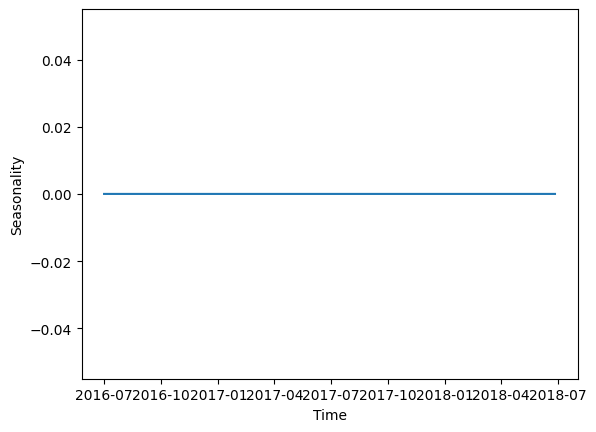

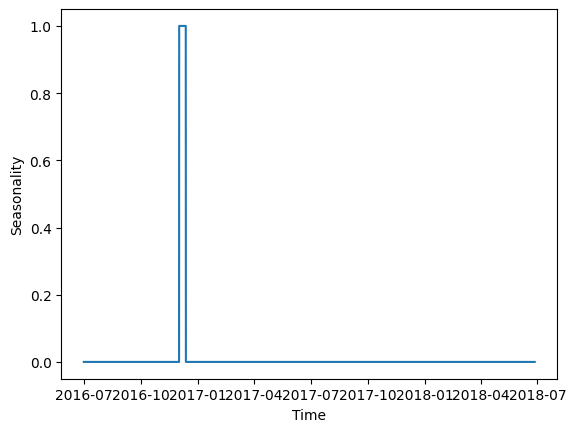

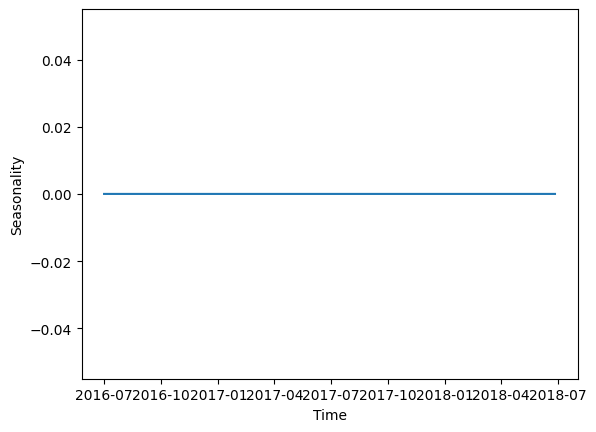

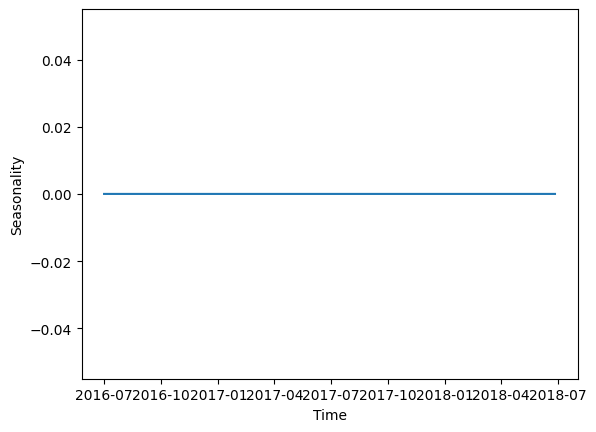

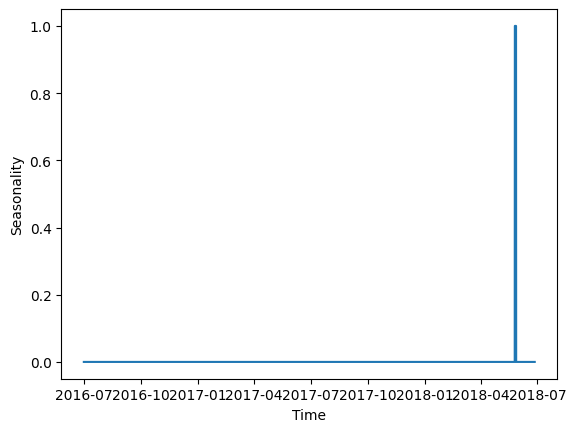

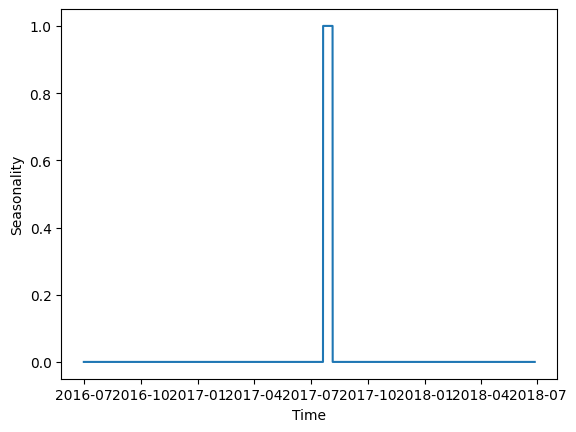

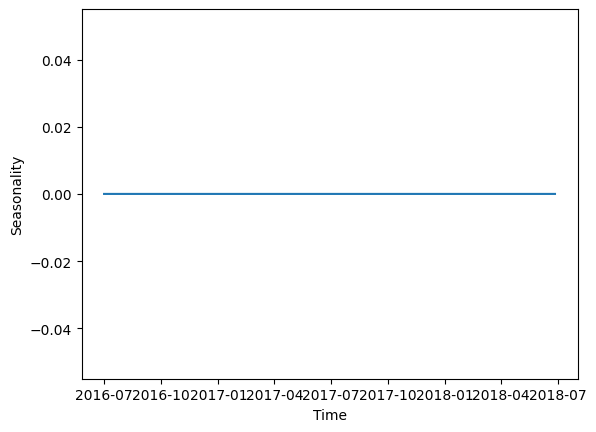

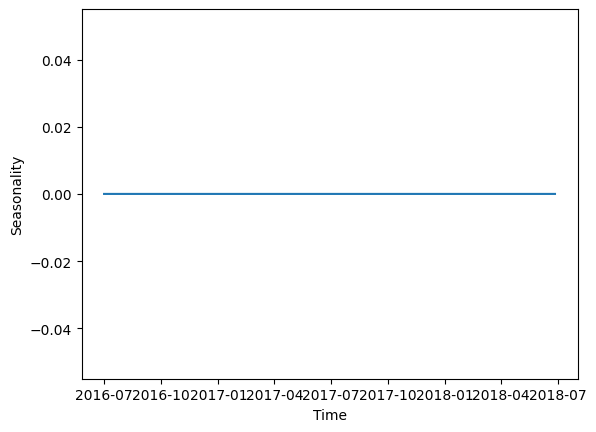

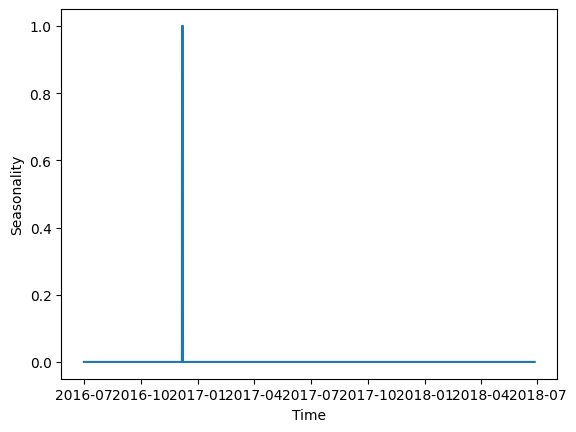

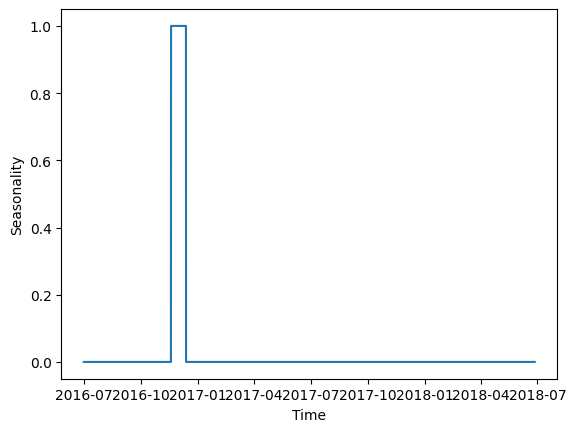

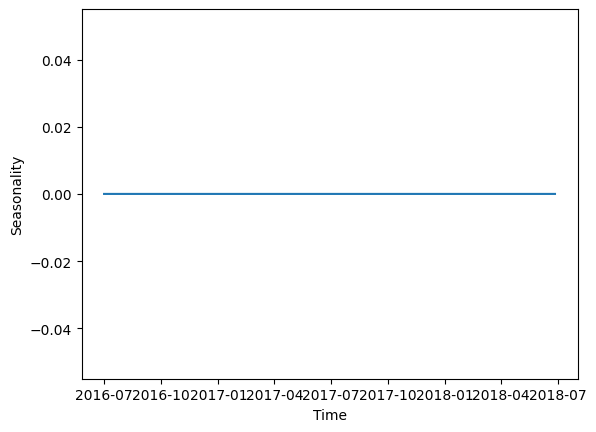

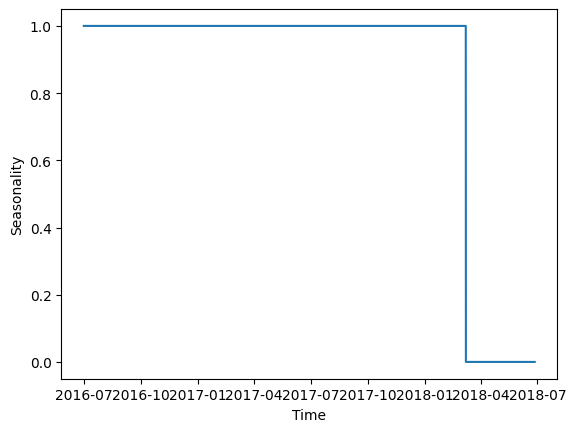

In [3]:
iter = 0
for height, coef in zip(height, wav_coef):
  iter = iter + 1

  # Assuming coef is your ndarray
  peaks_above, _ = find_peaks(coef, height)
  peaks_below, _ = find_peaks(-coef, height)
  # Combine the peaks from both conditions
  all_peaks = np.concatenate([peaks_above, peaks_below])
  # Sort the indices for plotting purposes
  all_peaks = np.sort(all_peaks)

  # Find zero-crossings by detecting sign changes
  coefsign = np.sign(coef)
  signchange = ((np.roll(coefsign, 1) - coefsign) != 0).astype(int)
  zero_crossings = np.where(signchange == 1)[0]
  #zero_crossings = np.where(np.diff(np.sign(coef)) != 0)[0]

  # Initialize an array to store indices of all oscillations
  all_oscillations = []

  if all_peaks.size == 0:
    print(f'All points under {height}')
    continue

  if all_peaks[0] < zero_crossings[0]:
    i = zero_crossings[0]
    all_oscillations.extend(range(0, i))

  # Iterate through zero-crossings to identify entire oscillations
  for i in range(len(zero_crossings) - 1):
      start_index = zero_crossings[i]
      end_index = zero_crossings[i + 1]

      # Check if there are peaks above the threshold within the interval
      if np.max(coef[start_index:end_index]) > height or np.min(coef[start_index:end_index]) < -height:
          all_oscillations.extend(range(start_index, end_index))


  # Check if the last peak is above the threshold
  if all_peaks[-1] > zero_crossings[-1]:
      start_index = zero_crossings[-1]
      end_index = all_peaks[-1]


      # Extend the oscillation to the right if values are increasing
      while end_index < len(coef) - 1 and coef[end_index] > coef[end_index + 1]:
          end_index += 1

      all_oscillations.extend(range(start_index, end_index + 1))

  # Convert the list to a NumPy array
  all_oscillations = np.unique(all_oscillations).tolist()

  # Plotting
  plt.plot(coef)
  #plt.plot(all_peaks, coef[all_peaks], "xk")
  plt.plot(zero_crossings, coef[zero_crossings], "xk")
  plt.axhline(y=0, color='r', linestyle='--', label='Zero')
  plt.axvspan(all_oscillations[0], all_oscillations[-1], color='green', alpha=0.3, label='Valid Oscillations')
  plt.title(f'Oscillations starting from zero with peaks above {height} or below {-height}')
  plt.legend()
  plt.show()


  # Check for consecutive index
  for i in range(len(all_oscillations)-1):
    if all_oscillations[i]+1 != all_oscillations[i+1]:
      count = all_oscillations[i+1]-all_oscillations[i]
      if time_diff == 0:
        if (iter % 4) == 1 and count <= 24:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif (iter % 4) == 2 and count <= 24*7:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif (iter % 4) == 3 and count <= 24*28:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif (iter % 4) == 0 and count <= 24*360:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      elif time_diff == 1:
        if (iter % 3) == 1 and count <= 7:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif (iter % 3) == 2 and count <= 28:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif (iter % 3) == 0 and count <= 360:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      elif time_diff == 2:
        if (iter % 2) == 1 and count <= 4:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif (iter % 2) == 0 and count <= 4*12:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      else:
        if count <= 12:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))

  all_oscillations = np.unique(all_oscillations)

  # Create a new list to store the non-consecutive indices
  non_consecutive_indices = []

  # Initialize a variable to store the count threshold based on time_diff and iter
  if time_diff == 0:
      if (iter % 4) == 1:
          count_threshold = 24
      elif (iter % 4) == 2:
          count_threshold = 24 * 7
      elif (iter % 4) == 3:
          count_threshold = 24 * 28
      elif (iter % 4) == 0:
          count_threshold = 24 * 360
  elif time_diff == 1:
      if (iter % 3) == 1:
          count_threshold = 7
      elif (iter % 3) == 2:
          count_threshold = 28
      elif (iter % 3) == 0:
          count_threshold = 360
  elif time_diff == 2:
      if  (iter % 2) == 1:
          count_threshold = 4
      elif (iter % 2) == 0:
          count_threshold = 4 * 12
  else:
      count_threshold = 12


  # Iterate through all_oscillations and check for consecutive points
  i = 0
  while i < len(all_oscillations):
      start_index = all_oscillations[i]
      end_index = all_oscillations[i]

      # Find the end of the consecutive sequence
      while i < len(all_oscillations) - 1 and all_oscillations[i] + 1 == all_oscillations[i+1]:
          end_index = all_oscillations[i+1]
          i += 1

      # Check if the consecutive sequence is shorter than the count threshold
      count = end_index - start_index + 1
      if count <= count_threshold:
          non_consecutive_indices.extend(range(start_index, end_index + 1))

      i += 1

  # Remove consecutive indices shorter than the count threshold from all_oscillations
  all_oscillations = np.array([index for index in all_oscillations if index not in non_consecutive_indices])

  i=0

  for i in range(len(all_oscillations)-1):
    if all_oscillations[i]+1 != all_oscillations[i+1]:
      print(f"No consecutive index {all_oscillations[i]}-{all_oscillations[i+1]}")

  print(all_oscillations)

  # Itera su ogni indice in all_oscillations
  for idx in all_oscillations:
    if time_diff == 0:
      final_result[idx, (iter - 1) // 4, (iter - 1) % 4] = 1
    elif time_diff == 1:
      final_result[idx, (iter - 1) // 3, (iter - 1) % 3] = 1
    elif time_diff == 2:
      final_result[idx, (iter - 1) // 2, (iter - 1) % 2] = 1
    else:
      final_result[idx, iter - 1, 0] = 1

  print(final_result.shape)

torch.save(final_result, 'result.pt')
# Plotting
for i in range(final_result.shape[1]):
    for j in range(final_result.shape[2]):
        plt.plot(time_index, final_result[:, i, j])
        plt.xlabel('Time')
        plt.ylabel('Seasonality')
        plt.show()